In [1]:
FN = 'predict'

In [3]:
import keras
keras.__version__

'1.0.1'

Generate headlines using the "simple" model from http://arxiv.org/pdf/1512.01712v1.pdf

Use indexing of tokens from [vocabulary-embedding](./vocabulary-embedding.ipynb) this does not clip the indexes of the words to `vocab_size`.

Use the index of outside words to replace them with several `oov` words (`oov` , `oov0`, `oov`...) that appear in the same description and headline. This will allow headline generator to replace the oov with the same word in the description

In [4]:
FN0 = 'vocabulary-embedding'

we will generate predictions using the model generated in this notebook

In [5]:
FN1 = 'train'

input data (`X`) is made from `maxlend` description words followed by `eos`
followed by headline words followed by `eos`
if description is shorter than `maxlend` it will be left padded with `empty`
if entire data is longer than `maxlen` it will be clipped and if it is shorter it will be padded.

labels (`Y`) are the headline words followed by `eos` and clipped or padded to `maxlenh`

In other words the input is made from a `maxlend` half in which the description is padded from the left
and a `maxlenh` half in which `eos` is followed by a headline followed by another `eos` if there is enough space.

The labels match only the second half and 
the first label matches the `eos` at the start of the second half (following the description in the first half)

the model parameters should be identical with what used in training but notice that `maxlend` is flexible

In [50]:
maxlend=50 # 0 - if we dont want to use description at all
maxlenh=25
maxlen = maxlend + maxlenh
rnn_size = 512
rnn_layers = 3  # match FN1
batch_norm=False

the out of the first `activation_rnn_size` nodes from the top layer will be used for activation and the rest will be used to select predicted word

In [7]:
activation_rnn_size = 40 if maxlend else 0

In [8]:
# training parameters
seed=42
p_W, p_U, p_dense, p_emb, weight_decay = 0, 0, 0, 0, 0
optimizer = 'adam'
batch_size=64

In [9]:
nb_train_samples = 30000
nb_val_samples = 3000

# read word embedding

In [10]:
import cPickle as pickle

with open('data/%s.pkl'%FN0, 'rb') as fp:
    X, Y, embedding, idx2word, word2idx, glove_idx2idx = pickle.load(fp)
vocab_size, embedding_size = embedding.shape

In [11]:
nb_unknown_words = 10

In [12]:
print 'number of examples',len(X),len(Y)
print 'dimension of embedding space for words',embedding_size
print 'vocabulary size', vocab_size, 'the last %d words can be used as place holders for unknown/oov words'%nb_unknown_words
print 'total number of different words',len(idx2word), len(word2idx)
print 'number of words outside vocabulary which we can substitue using glove similarity', len(glove_idx2idx)
print 'number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov)',len(idx2word)-vocab_size-len(glove_idx2idx)

number of examples 684114 684114
dimension of embedding space for words 100
vocabulary size 40000 the last 10 words can be used as place holders for unknown/oov words
total number of different words 523734 523734
number of words outside vocabulary which we can substitue using glove similarity 122377
number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov) 361357


In [13]:
for i in range(nb_unknown_words):
    idx2word[vocab_size-1-i] = '<%d>'%i

In [14]:
for i in range(vocab_size-nb_unknown_words, len(idx2word)):
    idx2word[i] = idx2word[i]+'^'

In [15]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=nb_val_samples, random_state=seed)
len(X_train), len(Y_train), len(X_test), len(Y_test)

(681114, 681114, 3000, 3000)

In [16]:
del X, Y

In [17]:
ytest_lookup = dict((sum(t),i) for i,t in enumerate(Y_test))

In [18]:
def ytest_find(s):
    return ytest_lookup[sum(word2idx[w] for w in s.split())]

In [19]:
empty = 0
eos = 1
idx2word[empty] = '_'
idx2word[eos] = '~'

In [20]:
import numpy as np
from keras.preprocessing import sequence
from keras.utils import np_utils
import random, sys

In [21]:
def prt(label, x):
    print label+':',
    for w in x:
        print idx2word[w],
    print

# Model

In [22]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, RepeatVector, Merge, TimeDistributedDense
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.regularizers import l2

Using Theano backend.


In [23]:
# seed weight initialization
random.seed(seed)
np.random.seed(seed)

In [24]:
regularizer = l2(weight_decay) if weight_decay else None

start with a standaed stacked LSTM

In [25]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size,
                    input_length=maxlen,
                    W_regularizer=regularizer, dropout=p_emb, weights=[embedding], mask_zero=True))
for i in range(rnn_layers):
    lstm = LSTM(rnn_size, return_sequences=True, # batch_norm=batch_norm,
                   W_regularizer=regularizer, U_regularizer=regularizer,
                   b_regularizer=regularizer, dropout_W=p_W, dropout_U=p_U,
                  )
    model.add(lstm)
    model.add(Dropout(p_dense))

A special layer that reduces the input just to its headline part (second half).
For each word in this part it concatenate the output of the previous layer (RNN)
with a weighted average of the outputs of the description part.
In this only the last `rnn_size - activation_rnn_size` are used from each output.
The first `activation_rnn_size` output is used to computer the weights for the averaging.

In [26]:
from keras.layers.core import Lambda
import keras.backend as K

context_weight = K.variable(1.)
head_weight = K.variable(1.)
cross_weight = K.variable(0.)

def simple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:,:maxlend], X[:,maxlend:]
    head_activations, head_words = head[:,:,:n], head[:,:,n:]
    desc_activations, desc_words = desc[:,:,:n], desc[:,:,n:]
    
    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=([2],[2]))
    # make sure we dont use description words that are masked out
    assert mask.ndim == 2
    activation_energies = K.switch(mask[:, None, :maxlend], activation_energies, -1e20)
    
    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies,(-1,maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights,(-1,maxlenh,maxlend))

    # for every head word compute weighted average of desc words
    desc_avg_word = K.batch_dot(activation_weights, desc_words, axes=([2],[1]))
    return K.concatenate((context_weight*desc_avg_word, head_weight*head_words))


class SimpleContext(Lambda):
    def __init__(self):
        super(SimpleContext, self).__init__(simple_context)
        self.supports_masking = True

    def compute_mask(self, input, input_mask=None):
        return input_mask[:, maxlend:]
    
    def get_output_shape_for(self, input_shape):
        nb_samples = input_shape[0]
        n = 2*(rnn_size - activation_rnn_size)
        return (nb_samples, maxlenh, n)

In [27]:
if activation_rnn_size:
    model.add(SimpleContext())

In [28]:
# we are not going to fit so we dont care about loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Load

In [29]:
import h5py
def part_load(model, filepath, skipmodel=0, skipfile=0, n=100):
    f = h5py.File(filepath, mode='r')
    print filepath, f.attrs['nb_layers']
    print 'model', len(model.layers)

    kk = skipmodel
    for k in range(skipfile,min(f.attrs['nb_layers'], skipfile+n)):
        if kk >= len(model.layers):
            break
        print 'layer_{} -> {}'.format(k, kk),
        print type(model.layers[kk]),
        # This method does not make use of Sequential.set_weights()
        # for backwards compatibility.
        g = f['layer_{}'.format(k)]
        print  ' '.join(['param_{}'.format(p) for p in range(g.attrs['nb_params'])])
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        if len(model.layers[kk].get_weights()) != g.attrs['nb_params']:
            print "aborting size mismatch", len(model.layers[kk].get_weights())
            break
        model.layers[kk].set_weights(weights)
        kk += 1
    f.close()

In [30]:
part_load(model, 'data/%s.weights.pkl'%FN1)

data/160408-multilabel.weights.pkl 10
model 8
layer_0 -> 0 <class 'keras.layers.embeddings.Embedding'> param_0
layer_1 -> 1 <class 'keras.layers.recurrent.LSTM'> param_0 param_1 param_2 param_3 param_4 param_5 param_6 param_7 param_8 param_9 param_10 param_11
layer_2 -> 2 <class 'keras.layers.core.Dropout'> 
layer_3 -> 3 <class 'keras.layers.recurrent.LSTM'> param_0 param_1 param_2 param_3 param_4 param_5 param_6 param_7 param_8 param_9 param_10 param_11
layer_4 -> 4 <class 'keras.layers.core.Dropout'> 
layer_5 -> 5 <class 'keras.layers.recurrent.LSTM'> param_0 param_1 param_2 param_3 param_4 param_5 param_6 param_7 param_8 param_9 param_10 param_11
layer_6 -> 6 <class 'keras.layers.core.Dropout'> 
layer_7 -> 7 <class '__main__.SimpleContext'> 


In [31]:
def load_weights(model, filepath, layer):
    f = h5py.File(filepath, mode='r')
    print filepath, f.attrs['nb_layers']
    print 'model', len(model.layers)

    print 'layer_{}'.format(layer),
    # This method does not make use of Sequential.set_weights()
    # for backwards compatibility.
    g = f['layer_{}'.format(layer)]
    print  ' '.join(['param_{}'.format(p) for p in range(g.attrs['nb_params'])])
    weights = [np.array(g['param_{}'.format(p)]) for p in range(g.attrs['nb_params'])]
    f.close()
    return weights

In [32]:
weights = load_weights(model, 'data/%s.weights.pkl'%FN1,8)

data/160408-multilabel.weights.pkl 10
model 8
layer_8 param_0 param_1


In [33]:
for w in weights:
    print w.shape

(944, 40000)
(40000,)


In [34]:
n = 2*(rnn_size - activation_rnn_size)
n

944

In [35]:
# out very own softmax
def output2probs(output):
    output = np.dot(output, weights[0]) + weights[1]
    output -= output.max()
    output = np.exp(output)
    output /= output.sum()
    return output

In [36]:
def output2probs1(output):
    output0 = np.dot(output[:n//2], weights[0][:n//2,:])
    output1 = np.dot(output[n//2:], weights[0][n//2:,:])
    output = output0 + output1 # + output0 * output1
    output += weights[1]
    output -= output.max()
    output = np.exp(output)
    output /= output.sum()
    return output

# Test

In [37]:
def lpadd(x, maxlend=maxlend, eos=eos):
    """left (pre) pad a description to maxlend and then add eos.
    The eos is the input to predicting the first word in the headline
    """
    assert maxlend >= 0
    if maxlend == 0:
        return [eos]
    n = len(x)
    if n > maxlend:
        x = x[-maxlend:]
        n = maxlend
    return [empty]*(maxlend-n) + x + [eos]

In [38]:
samples = [lpadd([3]*26)]
# pad from right (post) so the first maxlend will be description followed by headline
data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')

In [39]:
np.all(data[:,maxlend] == eos)

True

In [40]:
data.shape,map(len, samples)

((1, 50), [26])

In [41]:
probs = model.predict(data, verbose=0, batch_size=1)
probs.shape

(1, 25, 944)

# Sample generation

In [42]:
# variation to https://github.com/ryankiros/skip-thoughts/blob/master/decoding/search.py
def beamsearch(predict, start=[empty]*maxlend + [eos], avoid=None, avoid_score=1,
               k=1, maxsample=maxlen, use_unk=True, oov=vocab_size-1, empty=empty, eos=eos, temperature=1.0):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    def sample(energy, n, temperature=temperature):
        """sample at most n different elements according to their energy"""
        n = min(n,len(energy))
        prb = np.exp(-np.array(energy) / temperature )
        res = []
        for i in xrange(n):
            z = np.sum(prb)
            r = np.argmax(np.random.multinomial(1, prb/z, 1))
            res.append(r)
            prb[r] = 0. # make sure we select each element only once
        return res

    dead_samples = []
    dead_scores = []
    live_samples = [list(start)]
    live_scores = [0]

    while live_samples:
        # for every possible live sample calc prob for every possible label 
        probs = predict(live_samples, empty=empty)
        assert vocab_size == probs.shape[1]

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        cand_scores[:,empty] = 1e20
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        if avoid:
            for a in avoid:
                for i, s in enumerate(live_samples):
                    n = len(s) - len(start)
                    if n < len(a):
                        # at this point live_sample is before the new word,
                        # which should be avoided, is added
                        cand_scores[i,a[n]] += avoid_score
        live_scores = list(cand_scores.flatten())
        

        # find the best (lowest) scores we have from all possible dead samples and
        # all live samples and all possible new words added
        scores = dead_scores + live_scores
        ranks = sample(scores, k)
        n = len(dead_scores)
        dead_scores = [dead_scores[r] for r in ranks if r < n]
        dead_samples = [dead_samples[r] for r in ranks if r < n]
        
        live_scores = [live_scores[r-n] for r in ranks if r >= n]
        live_samples = [live_samples[(r-n)//vocab_size]+[(r-n)%vocab_size] for r in ranks if r >= n]

        # live samples that should be dead are...
        # even if len(live_samples) == maxsample we dont want it dead because we want one
        # last prediction out of it to reach a headline of maxlenh
        def is_zombie(s):
            return s[-1] == eos or len(s) > maxsample
        
        # add zombies to the dead
        dead_scores += [c for s, c in zip(live_samples, live_scores) if is_zombie(s)]
        dead_samples += [s for s in live_samples if is_zombie(s)]
        
        # remove zombies from the living 
        live_scores = [c for s, c in zip(live_samples, live_scores) if not is_zombie(s)]
        live_samples = [s for s in live_samples if not is_zombie(s)]

    return dead_samples, dead_scores

In [43]:
# !pip install python-Levenshtein

In [44]:
def keras_rnn_predict(samples, empty=empty, model=model, maxlen=maxlen):
    """for every sample, calculate probability for every possible label
    you need to supply your RNN model and maxlen - the length of sequences it can handle
    """
    sample_lengths = map(len, samples)
    assert all(l > maxlend for l in sample_lengths)
    assert all(l[maxlend] == eos for l in samples)
    # pad from right (post) so the first maxlend will be description followed by headline
    data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')
    probs = model.predict(data, verbose=0, batch_size=batch_size)
    return np.array([output2probs(prob[sample_length-maxlend-1]) for prob, sample_length in zip(probs, sample_lengths)])

In [45]:
def vocab_fold(xs):
    """convert list of word indexes that may contain words outside vocab_size to words inside.
    If a word is outside, try first to use glove_idx2idx to find a similar word inside.
    If none exist then replace all accurancies of the same unknown word with <0>, <1>, ...
    """
    xs = [x if x < vocab_size-nb_unknown_words else glove_idx2idx.get(x,x) for x in xs]
    # the more popular word is <0> and so on
    outside = sorted([x for x in xs if x >= vocab_size-nb_unknown_words])
    # if there are more than nb_unknown_words oov words then put them all in nb_unknown_words-1
    outside = dict((x,vocab_size-1-min(i, nb_unknown_words-1)) for i, x in enumerate(outside))
    xs = [outside.get(x,x) for x in xs]
    return xs

In [46]:
def vocab_unfold(desc,xs):
    # assume desc is the unfolded version of the start of xs
    unfold = {}
    for i, unfold_idx in enumerate(desc):
        fold_idx = xs[i]
        if fold_idx >= vocab_size-nb_unknown_words:
            unfold[fold_idx] = unfold_idx
    return [unfold.get(x,x) for x in xs]

In [47]:
import sys
import Levenshtein

def gensamples(X=None, avoid=None, avoid_score=1, skips=2, k=10, batch_size=batch_size, short=True, temperature=1., use_unk=True):
    if X is None or isinstance(X,int):
        if X is None:
            i = random.randint(0,len(X_test)-1)
        else:
            i = X
        print 'HEAD %d:'%i,' '.join(idx2word[w] for w in Y_test[i])
        print 'DESC:',' '.join(idx2word[w] for w in X_test[i])
        sys.stdout.flush()
        x = X_test[i]
    else:
        x = [word2idx[w] for w in X.split()]
        
    if avoid:
        # avoid is a list of avoids. Each avoid is a string or list of word indeicies
        if isinstance(avoid,str) or isinstance(avoid[0], int):
            avoid = [avoid]
        avoid = [a.split() if isinstance(a,str) else a for a in avoid]
        avoid = [vocab_fold([w if isinstance(w,int) else word2idx[w] for w in a])
                 for a in avoid]

    print 'HEADS:'
    samples = []
    if maxlend == 0:
        skips = [0]
    else:
        skips = range(min(maxlend,len(x)), max(maxlend,len(x)), abs(maxlend - len(x)) // skips + 1)
    for s in skips:
        start = lpadd(x[:s])
        fold_start = vocab_fold(start)
        sample, score = beamsearch(predict=keras_rnn_predict, start=fold_start, avoid=avoid, avoid_score=avoid_score,
                                   k=k, temperature=temperature, use_unk=use_unk)
        assert all(s[maxlend] == eos for s in sample)
        samples += [(s,start,scr) for s,scr in zip(sample,score)]

    samples.sort(key=lambda x: x[-1])
    codes = []
    for sample, start, score in samples:
        code = ''
        words = []
        sample = vocab_unfold(start, sample)[len(start):]
        for w in sample:
            if w == eos:
                break
            words.append(idx2word[w])
            code += chr(w//(256*256)) + chr((w//256)%256) + chr(w%256)
        if short:
            distance = min([100] + [-Levenshtein.jaro(code,c) for c in codes])
            if distance > -0.6:
                print score, ' '.join(words)
        #         print '%s (%.2f) %f'%(' '.join(words), score, distance)
        else:
                print score, ' '.join(words)
        codes.append(code)
    return samples

In [48]:
seed = 8
random.seed(seed)
np.random.seed(seed)

In [49]:
samples = gensamples(X=2616, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEAD 2616: Billy Joel Lists in Sagaponack^
DESC: * Billy Joel is looking for a buyer in Sagaponack^ . Now that he and wife Katie Lee Joel are splitting up , the singer is planning to sell the two oceanfront^ properties he bought for her in 2007 . The four-bedroom mansion ( No . 1 ) and smaller beach bungalow^ ( No . 2 ) will be listed with Corcoran 's Biana^ Stepanian^ for a combined $ 35 million . * Richard Bressler^ , the former CFO of Viacom and now a managing
HEADS:
3.90008238831 LeftoverDome
5.0377739653 Leftovers
9.66735607459 Blogdome : The


In [53]:
i = ytest_find("18 Cake GIFs That 'll Make You Moist")
i

2615

In [54]:
samples = gensamples(X=i, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEAD 2615: 18 Cake GIFs That 'll Make You Moist^
DESC: Is it 350degF^ in here or is it just me ?
HEADS:
8.70401185904 Are You A 350degF^ ?


In [53]:
desc = "President Barack Obama 's re-election campaign is fundraising off of comments on Obama 's birth certificate by Mitt Romney 's son Matt ."

In [53]:
gensamples(X=desc, skips=2, batch_size=batch_size, k=10, temperature=1, use_unk=True, short=False);

HEADS:
21.71228711 Barack Obama : Mitt Romney Is ' The Election '
24.547378643 Barack Obama : Mitt Romney Is ' The Questions '
25.2409563339 Barack Obama : Mitt Romney Is ' The Leader ' ( VIDEO )
26.9220394431 Barack Obama : Mitt Romney Is ' The Leader ' '
28.5157001848 Barack Obama : Mitt Romney Is ' The Leader ' ( PHOTOS )
29.6317423849 Barack Obama : Mitt Romney Is ' The Leader ' ( VIDEO , VIDEO )
31.820416299 Barack Obama : Mitt Romney Is ' The Leader ' ( VIDEO ) ( VIDEO )
33.0995642521 Barack Obama : Mitt Romney Is ' The Leader ' ( PHOTOS ) POLL )
36.665858995 Barack Obama : Mitt Romney Is ' The Leader ' ( VIDEO , VIDEO ) ( VIDEO )
46.026810433 Barack Obama : Mitt Romney Is ' The Leader ' ( VIDEO , VIDEO ) ( VIDEO ,


In [80]:
desc = "What have you been listening to this year ? If you want to find out using cold , hard evidence , then Spotify 's new Year in Music tool will tell you ."

In [81]:
head = "Spotify Will Make You Smarter for Your App"

In [82]:
samples = gensamples(X=desc, skips=2, batch_size=batch_size, k=10, temperature=1)

HEADS:
22.4578751536 Spotify 's New App Lets You Stream Your Home


In [89]:
headline = samples[0][0][len(samples[0][1]):]

In [114]:
' '.join(idx2word[w] for w in headline)

"Spotify 's New App Lets You Stream Your Home ~"

In [91]:
avoid = headline

In [136]:
samples = gensamples(X=desc, avoid=avoid, avoid_score=.1, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
16.3492176738 Spotify Is Coming to Chromecast


In [137]:
avoid = samples[0][0][len(samples[0][1]):]

In [138]:
samples = gensamples(X=desc, avoid=avoid, avoid_score=.1, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
18.7877172471 Spotify Is Getting a New Year 's


In [148]:
len(samples)

20

# Weights

In [55]:
wmodel = Sequential()
wmodel.add(Embedding(vocab_size, embedding_size,
                    input_length=maxlen,
                    W_regularizer=regularizer, dropout=p_emb, weights=[embedding], mask_zero=True))
for i in range(rnn_layers):
    lstm = LSTM(rnn_size, return_sequences=True, # batch_norm=batch_norm,
                   W_regularizer=regularizer, U_regularizer=regularizer,
                   b_regularizer=regularizer, dropout_W=p_W, dropout_U=p_U,
                  )
    wmodel.add(lstm)
    wmodel.add(Dropout(p_dense))

In [56]:
def wsimple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:,:maxlend], X[:,maxlend:]
    head_activations, head_words = head[:,:,:n], head[:,:,n:]
    desc_activations, desc_words = desc[:,:,:n], desc[:,:,n:]
    
    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=([2],[2]))
    # make sure we dont use description words that are masked out
    assert mask.ndim == 2
    activation_energies = K.switch(mask[:, None, :maxlend], activation_energies, -1e20)
    
    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies,(-1,maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights,(-1,maxlenh,maxlend))

    return activation_weights


class WSimpleContext(Lambda):
    def __init__(self):
        super(WSimpleContext, self).__init__(wsimple_context)
        self.supports_masking = True

    def compute_mask(self, input, input_mask=None):
        return input_mask[:, maxlend:]
    
    def get_output_shape_for(self, input_shape):
        nb_samples = input_shape[0]
        n = 2*(rnn_size - activation_rnn_size)
        return (nb_samples, maxlenh, n)

In [57]:
wmodel.add(WSimpleContext())

In [58]:
wmodel.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [59]:
part_load(wmodel, 'data/%s.weights.pkl'%FN1)

data/160408-multilabel.weights.pkl 10
model 8
layer_0 -> 0 <class 'keras.layers.embeddings.Embedding'> param_0
layer_1 -> 1 <class 'keras.layers.recurrent.LSTM'> param_0 param_1 param_2 param_3 param_4 param_5 param_6 param_7 param_8 param_9 param_10 param_11
layer_2 -> 2 <class 'keras.layers.core.Dropout'> 
layer_3 -> 3 <class 'keras.layers.recurrent.LSTM'> param_0 param_1 param_2 param_3 param_4 param_5 param_6 param_7 param_8 param_9 param_10 param_11
layer_4 -> 4 <class 'keras.layers.core.Dropout'> 
layer_5 -> 5 <class 'keras.layers.recurrent.LSTM'> param_0 param_1 param_2 param_3 param_4 param_5 param_6 param_7 param_8 param_9 param_10 param_11
layer_6 -> 6 <class 'keras.layers.core.Dropout'> 
layer_7 -> 7 <class '__main__.WSimpleContext'> 


## test

In [60]:
seed = 8
random.seed(seed)
np.random.seed(seed)

In [61]:
context_weight.set_value(np.float32(1.))
head_weight.set_value(np.float32(1.))

In [62]:
samples = gensamples(X=2617, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEAD 2617: Native American Groups Officially Respond To Leonardo DiCaprio 's Call To Action
DESC: Representatives of the groups depicted in The Revenant^ spoke with BuzzFeed News about the actor 's Golden Globes speech calling on listeners to `` protect ... indigenous lands . ''
HEADS:
20.5102220631 How The Golden Globes Will Make You Cry


In [81]:
sample = samples[0][0]

In [82]:
' '.join([idx2word[w] for w in sample])

"_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ Representatives of the groups depicted in The trainwreck spoke with BuzzFeed News about the actor 's Golden Globes speech calling on listeners to `` protect ... indigenous lands . '' ~ How The Golden Globes Will Make You Cry ~"

In [83]:
data = sequence.pad_sequences([sample], maxlen=maxlen, value=empty, padding='post', truncating='post')
data.shape

(1, 75)

In [84]:
weights = wmodel.predict(data, verbose=0, batch_size=1)
weights.shape

(1, 25, 50)

In [104]:
startd = np.where(data[0,:] != empty)[0][0]
lenh = np.where(data[0,maxlend+1:] == eos)[0][0]
startd, lenh

(20, 8)

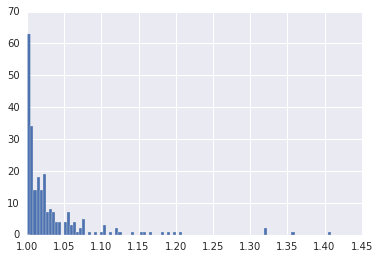

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(np.array(weights[0,:lenh,startd:].flatten()+1), bins=100);

In [106]:
import numpy as np
from IPython.core.display import display, HTML

def heat(sample,weights,dark=0.3):
    weights = (weights - weights.min())/(weights.max() - weights.min() + 1e-4)
    html = ''
    fmt = ' <span style="background-color: #{0:x}{0:x}ff">{1}</span>'
    for t,w in zip(sample,weights):
        c = int(256*((1.-dark)*(1.-w)+dark))
        html += fmt.format(c,idx2word[t])
    display(HTML(html))

In [107]:
heat(sample, weights[0,-1])

In [121]:
import pandas as pd
import seaborn as sns

In [115]:
columns = [idx2word[data[0,i]] for i in range(startd,maxlend)]
rows = [idx2word[data[0,i]] for i in range(maxlend+1,maxlend+lenh+1)]

"Representatives of the groups depicted in The trainwreck spoke with BuzzFeed News about the actor 's Golden Globes speech calling on listeners to `` protect ... indigenous lands . ''"

In [122]:
df = pd.DataFrame(weights[0,:lenh,startd:],columns=columns,index=rows)

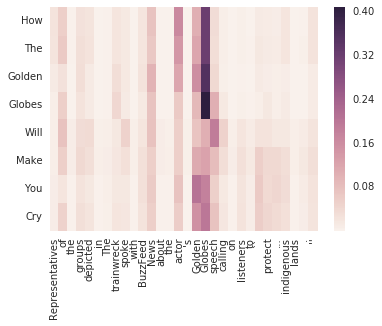

In [129]:
sns.heatmap(df);